# Image 2 Sketch: A Novel Approach for Converting Images to Resemble Hand Drawn Sketches Using an Orthogoanl Gaussian Lattice Feature Extraction Method 

In this project I propose a novel method for converting a image (or video) into an image resembling a hand drawn sketch by an artist. There are several methods to acheieve this using Canny Edge Detection, Gaussian Blur Inversion and the basic txture convolution. 

We shall see below all these techniques and then introduce the Lattice Based ones which in my opinion give much more natural and seemingly human impressions. Creating a sketch or any other artform is highly subjetive and hence the results can't be tested using any metric, but rather the observr must be the judge of whether the results are good or not.

We will also introuce some control parameters that the user can vary to yeild the results that he/she wishes to produce.

## The Problem
The problem statement is simple. Given an image convert it into a hand drawn sketch such that it looks as if a human sketch artist drew it and the placing one generated by this algorithm, or one generated by an actual artist should be indiscerable, or rather act as a Turing Test for this algorith.

## A Few Results


In [1]:
# importig the standard packages
import numpy as np
import cv2
import pprint
import matplotlib.pyplot as plt

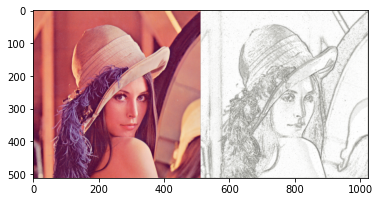

In [2]:
# Below are a few results of this algorithm on some standard images
I = cv2.cvtColor(cv2.imread('../assets/lenna-results.png'), cv2.COLOR_BGR2RGB)
plt.imshow(I)

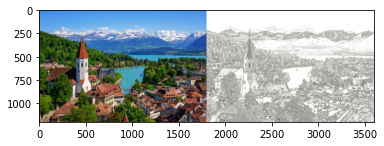

In [3]:
I = cv2.cvtColor(cv2.imread('../assets/swiss-1-results.png'), cv2.COLOR_BGR2RGB)
plt.imshow(I)

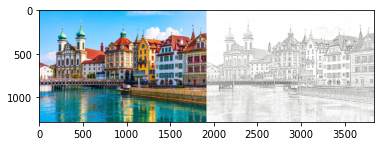

In [4]:
# Below are a few results of this algorithm on some standard images
I = cv2.cvtColor(cv2.imread('../assets/swiss-3-result.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(I)

## The Gaussian Blur-Blend Method
The Gaussian Blur Blend Method follows certain steps to create a sketch composite. We first take the image and convert it to grayscale. 

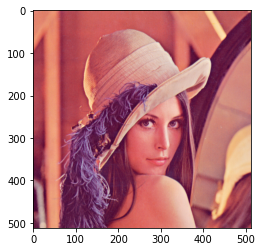

In [5]:
# loaing in the image
J = cv2.imread('../data/lenna.png')
I = cv2.cvtColor(J, cv2.COLOR_BGR2RGB)
plt.imshow(I)

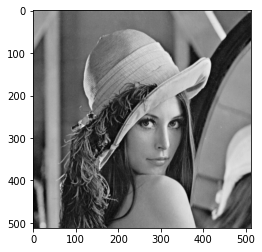

In [6]:
# creating the grayscale image
img_gray = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

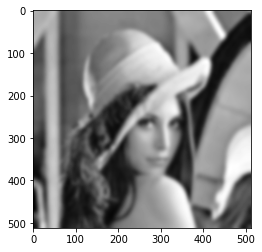

In [7]:
# we now define a blur factor and define a Gaussian Convolutional Mask Size
SKETCH_DENSITY = 27
blur_factor = (SKETCH_DENSITY, ) * 2
img_blur = cv2.GaussianBlur(img_gray, blur_factor, 0, 0)
plt.imshow(img_blur, cmap='gray')

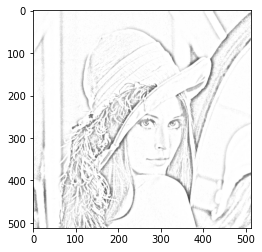

In [37]:
# Blending the image with the Gaussian using dodge and burn
img_blend = cv2.divide(img_gray, img_blur, scale=256)
img_blend = cv2.cvtColor(img_blend, cv2.COLOR_GRAY2BGR)
plt.imshow(img_blend, cmap='gray')

## Orthogonal Gaussian Lattice Feature Extraction Method
We load in our image and convert it to grayscale and normalize it. Loading in the image.

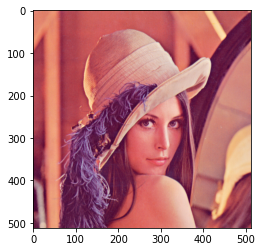

In [9]:
I = cv2.imread('../data/lenna.png')
J = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
plt.imshow(J)

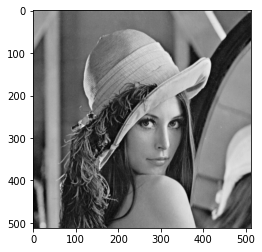

In [10]:
# converting to grayscale and normalizing
G = cv2.cvtColor(J, cv2.COLOR_RGB2GRAY)
G = G / 255
plt.imshow(G, cmap='gray')

In [11]:
# we will now load in the 3 Gaussian Parameters

# Constants
SQRT_2PI = np.sqrt(2 * np.pi)
SQRT_2PI_INV = 1 / SQRT_2PI
EPSILON = 10 ** -5

# Gaussian Parameters
MU = (0, 0, 0)
SIGMA_FACTOR = (4, 2, 1)
SIGMA = np.array(SIGMA_FACTOR) * SQRT_2PI_INV
A = (1, 1, 1)

In [12]:
#defining the Gaussian Inverse function
def inverse_gaussian(mu, sigma, Amp, y) -> np.ndarray:
    """:returns x (input) given output of gaussian function y"""
    return np.nan_to_num(sigma * np.sqrt(-2 * np.log(y * sigma * SQRT_2PI / Amp))) + mu

In [13]:
# computing the Gaussian Inverses
gauss_inv = np.array([inverse_gaussian(mu, sigma, a, G) for mu, sigma, a in zip(MU, SIGMA, A)]) + EPSILON

c:\users\anish\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


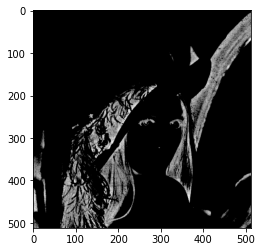

In [14]:
# viewing the 3 gaussian inverses, gaussian-1
plt.imshow(gauss_inv[0], cmap='gray')

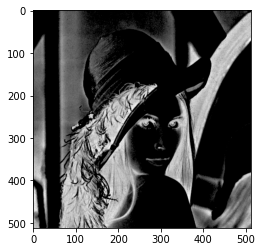

In [15]:
# the second gaussian
plt.imshow(gauss_inv[1], cmap='gray')

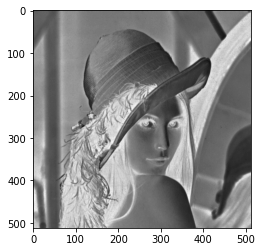

In [16]:
# the third gaussian
plt.imshow(gauss_inv[2], cmap='gray')

In [17]:
# We now compute the Simple Graphs from the 3 Gaussian Inverses. We first define the Vertex, Edge and SimpleGraph class

In [18]:
class Edge:
    def __init__(self, vertex_1, vertex_2):
        self.vertex_1 = vertex_1
        self.vertex_2 = vertex_2

    def other(self, position: tuple) -> tuple:
        """":returns the position tuple (x, y) of the vertex in the edge which doesn't equal position"""
        if self.vertex_1 == position:
            return self.vertex_2
        else:
            return self.vertex_1

In [19]:
class Vertex:
    def __init__(self, x: int, y: int):
        self.x = x
        self.y = y
        self.edges = set()
        self.in_degree = 0
        self.out_degree = 0

    def add_edge(self, edge: Edge):
        self.edges.add(edge)
        self.out_degree += 1

    def __str__(self):
        return str(self.degree())

    def position(self):
        return self.x, self.y

    def degree(self):
        return self.in_degree + self.out_degree

In [20]:
class DirectedGraph:
    def __init__(self, image_dimensions: tuple):
        # map of pixel point to a vertex {(x, y): tuple --> vertex: Vertex}
        self.vertices: dict = {}
        self.height, self.width, _ = image_dimensions

        for h in range(self.height):
            for w in range(self.width):
                self.add_vertex(h, w)

    # here the vertical row is represented as y and column as x
    def add_vertex(self, x, y):
        self.vertices[(x, y)] = Vertex(x, y)

    def add_edge(self, from_vertex: tuple, to_vertex: tuple):
        edge = Edge(from_vertex, to_vertex)
        self.vertices[from_vertex].add_edge(edge)
        self.vertices[to_vertex].in_degree += 1

    def components(self) -> list:
        """:return a list of sets of vertices that where each represent a component"""
        result = []
        used_vertices = set()

        for position, vertex in self.vertices.items():
            if position in used_vertices:
                continue

            component = set()
            queue = [vertex]

            while queue:
                current_vertex = queue.pop()
                if current_vertex.position() in used_vertices:
                    continue
                used_vertices.add(current_vertex.position())

                # adding children to the queue
                for edge in current_vertex.edges:
                    other_vertex = self.vertices[edge.to_vertex].position()
                    queue.append(self.vertices[other_vertex])

                # adding current vertex into the component
                component.add(current_vertex.position())

            # adding the component into the resulting list
            result.append(component.copy())

        return result

In [21]:
def deviation_vector(gaussian_inv, center_pos, surrounding_pos) -> np.ndarray:
    # when mu is not zero it should be (G_s - mu) / (G_c - mu) but in our case mu is zero so we take reduced formula
    return gaussian_inv[:, surrounding_pos[0], surrounding_pos[1]] / gaussian_inv[:, center_pos[0], center_pos[1]]

In [22]:
def bounded_by(ratio_vector: np.ndarray, bounds: tuple) -> np.ndarray:
    lower_bounds, upper_bounds = bounds
    lower_bounds, upper_bounds = np.array(lower_bounds), np.array(upper_bounds)
    return (ratio_vector < upper_bounds).astype(np.int) + (ratio_vector > lower_bounds).astype(np.int) == 2


def add_edges_to_lattices_based_on_deviation_spread_ratio(directed_graphs: list, vector: np.ndarray, bounds: tuple,
                                                          central_pixel: tuple, surrounding_pixel: tuple):
    allowed_bounds = bounded_by(vector, bounds)
    for directed_graph, allowed in zip(directed_graphs, allowed_bounds):
        if allowed:
            directed_graph.add_edge(central_pixel, surrounding_pixel)

In [23]:
directed_graphs = [DirectedGraph(I.shape) for _ in range(3)]
height, width, _ = I.shape
bounds = ((0.86, 0.88, 0.92), (1.162, 1.136, 1.087))

for row in range(height):
    for column in range(width):
        if column + 1 < width:
            right = deviation_vector(gauss_inv, center_pos=(row, column), surrounding_pos=(row, column + 1))
            add_edges_to_lattices_based_on_deviation_spread_ratio(directed_graphs, right, bounds, (row, column),
                                                                  (row, column + 1))

        if column + 1 < width and row + 1 < height:
            bottom_right = deviation_vector(gauss_inv, center_pos=(row, column),
                                            surrounding_pos=(row + 1, column + 1))
            add_edges_to_lattices_based_on_deviation_spread_ratio(directed_graphs, bottom_right, bounds,
                                                                  (row, column), (row + 1, column + 1))

        if row + 1 < height:
            bottom = deviation_vector(gauss_inv, center_pos=(row, column), surrounding_pos=(row + 1, column))
            add_edges_to_lattices_based_on_deviation_spread_ratio(directed_graphs, bottom, bounds, (row, column),
                                                                  (row + 1, column))

        if row + 1 < height and column - 1 >= 0:
            bottom_left = deviation_vector(gauss_inv, center_pos=(row, column),
                                           surrounding_pos=(row + 1, column - 1))
            add_edges_to_lattices_based_on_deviation_spread_ratio(directed_graphs, bottom_left, bounds,
                                                                  (row, column), (row + 1, column - 1))

In [24]:
# after computing the 3 simple graphs we compute the vertex shaded images for all 3 graphs
# Defining Vertex Colors
COLOR_1 = np.array([255, 255, 255])
COLOR_2 = np.array([229, 232, 232])
COLOR_3 = np.array([204, 209, 209])
COLOR_4 = np.array([178, 186, 187])
COLOR_5 = np.array([153, 163, 164])
COLOR_6 = np.array([127, 140, 141])
COLOR_7 = np.array([97, 106, 107])
COLOR_8 = np.array([81, 90, 90])
COLOR_9 = np.array([66, 73, 73])

In [25]:
# Deciding the color of a vertex (pixel) based on the degree of a vertex
def get_vertex_color(degree: int) -> np.ndarray:
    if degree == 0:
        return COLOR_9
    elif degree == 1:
        return COLOR_8
    elif degree == 2:
        return COLOR_7
    elif degree == 3:
        return COLOR_6
    elif degree == 4:
        return COLOR_5
    elif degree == 5:
        return COLOR_4
    elif degree == 6:
        return COLOR_3
    elif degree == 7:
        return COLOR_2
    elif degree == 8:
        return COLOR_1

In [26]:
# function for shading vertixes in a Lattice
def lattice_vertex_shading_image(lattice: DirectedGraph, I: np.ndarray):
    L = np.zeros(I.shape, dtype=np.uint8)
    for position, vertex in lattice.vertices.items():
        L[position[0], position[1], :] = get_vertex_color(vertex.degree())
    return L

In [27]:
L = [lattice_vertex_shading_image(lattice, J) for lattice in directed_graphs]

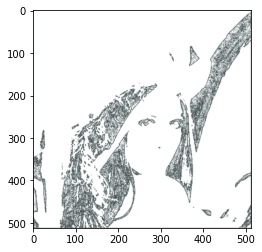

In [28]:
# first gaussian lattice vertex representation
plt.imshow(L[0])

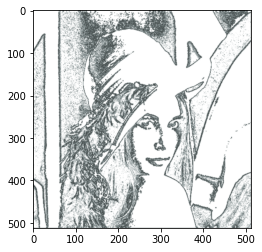

In [29]:
# second gaussian lattice vertex representation
plt.imshow(L[1])

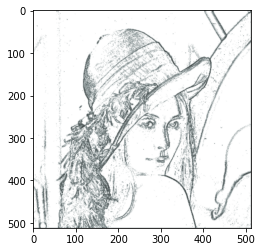

In [30]:
# third gaussian lattice vertex representation
plt.imshow(L[2])

In [38]:
print(L[0].shape)
print(img_blend.shape)

(512, 512, 3)
(512, 512, 3)


In [39]:
W = (0.2, 0.05, 0.7)
mask_weight = 1 - sum(W)
R = np.array(sum(weight * l for weight, l in zip(L, W)) + img_blend * mask_weight, dtype=np.uint8)

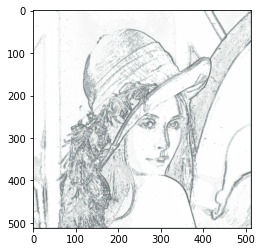

In [40]:
plt.imshow(R)

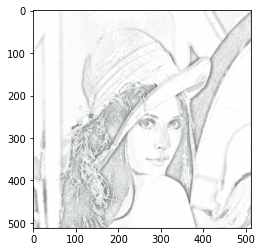

In [41]:
# taking different Weights and computing the linear fusion result
W = (0.2, 0.05, 0.2)
mask_weight = 1 - sum(W)
R = np.array(sum(weight * l for weight, l in zip(L, W)) + img_blend * mask_weight, dtype=np.uint8)
plt.imshow(R)

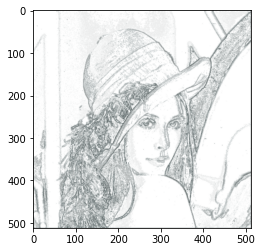

In [42]:
# taking different Weights and computing the linear fusion result
W = (0.4, 0.1, 0.5)
mask_weight = 1 - sum(W)
R = np.array(sum(weight * l for weight, l in zip(L, W)) + img_blend * mask_weight, dtype=np.uint8)
plt.imshow(R)